# Predicting Wine From User Sentiment

Project Summary
This project aims to predict the type of wine a user would like to drink, given text describing how they feel. Using Machine Learning, we'd like to be able to classify potential types of wine. The dataset was found on Kaggle.

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
raw_data = pd.read_csv('winemag-data-130k-v2.csv')

# Data Exploration

In [3]:
#lines of CSV file because actual file is too large
df = raw_data.head(15000)

In [4]:
# Get column names
df.columns

Index(['id', 'country', 'description', 'designation', 'points', 'price',
       'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery'],
      dtype='object')

In [5]:
# Check how many NaN values there are
df.isna().sum()

id                          0
country                     8
description                 0
designation              4334
points                      0
price                    1055
province                    8
region_1                 2533
region_2                 9170
taster_name              3071
taster_twitter_handle    3615
title                       0
variety                     0
winery                      0
dtype: int64

In [6]:
df.nunique()

id                       15000
country                     37
description              14889
designation               7658
points                      21
price                      192
province                   273
region_1                   822
region_2                    17
taster_name                 18
taster_twitter_handle       14
title                    14865
variety                    390
winery                    6992
dtype: int64

# Data Cleaning + Preprocessing

### Preprocessing Columns

In [7]:
# Drop columns, set index, drop NaNs and duplicates
df.drop(columns=["taster_name", "taster_twitter_handle"], inplace=True)
df = df.set_index('id')
df.dropna(axis=0, inplace=True)
df.drop_duplicates(inplace=True)
df = df.reset_index(drop=True)

/var/folders/ht/ljrb1cwj3xg1_7ttyxw6hfj40000gn/T/ipykernel_99214/1645977283.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["taster_name", "taster_twitter_handle"], inplace=True)


In [8]:
df.head(5)

,country,description,designation,points,price,province,region_1,region_2,title,variety,winery
0,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
1,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
2,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,Bianchi 2011 Signature Selection Merlot (Paso ...,Merlot,Bianchi
3,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,87,69.0,California,Sonoma Coast,Sonoma,Castello di Amorosa 2011 King Ridge Vineyard P...,Pinot Noir,Castello di Amorosa
4,US,"Rustic and dry, this has flavors of berries, c...",Puma Springs Vineyard,86,50.0,California,Dry Creek Valley,Sonoma,Envolve 2010 Puma Springs Vineyard Red (Dry Cr...,Red Blend,Envolve


In [9]:
# Check shape to check number of entries available
df.shape

(3907, 11)

### Natural Language Processing

In [10]:
# Import NLTK Corpus for NLP and RegEx library
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
 
# Get stop words and add any other common ones from text file into the set
stopWords = set(stopwords.words('english'))

# Remove \n characters
with open('Common English Words.txt') as file:
    cleaned_cwords = [word[:len(word)-1] for word in file.readlines()]

# Add text file common words to stop words set
for c_words in cleaned_cwords:
    stopWords.add(c_words)
    
# Remove wine variety names in description list by adding variety names to stop word list
for wine_variety in df['variety']:
    stopWords.add(wine_variety)

In [11]:
lemmatizer = WordNetLemmatizer()

# Take the description column and take out stop words
processed_sentences = []
for desc in df['description']:
    preprocessed = [word.lower().strip() for word in desc.split() if (word.lower() not in stopWords)]
    
    # Perform regex to remove digits and % signs from list
    for index, word in enumerate(preprocessed):
        match = re.search("[\d%,.]",word)
        
        # Check if there is a Match object and remove that item from list
        if match is not None:
            preprocessed.pop(index)
    
    # Lemmatized words in preprocessed list to prevent duplicate word count
    preprocessed = [lemmatizer.lemmatize(word) for word in preprocessed]
        
    # Combine all cleaned words into string for storage
    processed_sentences.append(" ".join(preprocessed))

In [12]:
# Store as new column in dataframe
for i in range(df.shape[0]):
    df.loc[i,"processed_description"] = processed_sentences[i]

### Feature Engineering

In [13]:
# Create mapping dictionaries for columns that need to be mapped
mapped_wineries = {winery:index for index,winery in enumerate(list(df['winery'].unique()))}
mapped_province = {province:index for index,province in enumerate(list(df['province'].unique()))}
mapped_variety = {variety:index for index,variety in enumerate(list(df['variety'].unique()))}

In [14]:
# Create new copy of original df to store mapped values
df_mapped = df.copy()

In [15]:
# Map the columns with numeric variables for PCA 
df_mapped['winery'].replace(list(mapped_wineries.keys()), list(mapped_wineries.values()), inplace=True)
df_mapped['province'].replace(list(mapped_province.keys()), list(mapped_province.values()), inplace=True)
df_mapped['variety'].replace(list(mapped_variety.keys()), list(mapped_variety.values()), inplace=True)

In [16]:
df_mapped.tail(5)

,country,description,designation,points,price,province,region_1,region_2,title,variety,winery,processed_description
3902,US,Made from estate-grown fruit sourced high in t...,Estate,88,29.0,1,Sierra Foothills,Sierra Foothills,Naggiar 2009 Estate Petite Sirah (Sierra Footh...,8,650,"estate-grown sourced sierra black, true-to-typ..."
3903,US,"A five-grape Bordeaux-style blend, this has a ...",Radieux,88,31.0,2,Columbia Valley (WA),Columbia Valley,Ott & Murphy 2008 Radieux Red (Columbia Valley...,7,1355,five-grape bordeaux-style scent drift earthier...
3904,US,"Restrained, rather savory aromas of dill, fenn...",Dry,88,16.0,3,Finger Lakes,Finger Lakes,Silver Thread 2011 Dry Riesling (Finger Lakes),12,363,"savory aroma fennel, saline nuance surprisingl..."
3905,US,"This is very spicy and smooth, with floral acc...",The Illusionist,88,45.0,2,Columbia Valley (WA),Columbia Valley,Sleight of Hand 2009 The Illusionist Red (Colu...,3,1021,spicy floral accent plummy drink although fade...
3906,US,"There are tons of rich, ripe flavors in this s...",Anna's Vineyard Version,88,36.0,1,Paso Robles,Central Coast,Adelaida 2009 Anna's Vineyard Version Red (Pas...,14,1161,ton ripe flavor high-alcohol california rendit...


In [17]:
# Drop original description column
df = df.drop(['description'],axis=1)
df_mapped = df_mapped.drop(['description'],axis=1)

# Data Visualization

In [18]:
import seaborn as sns

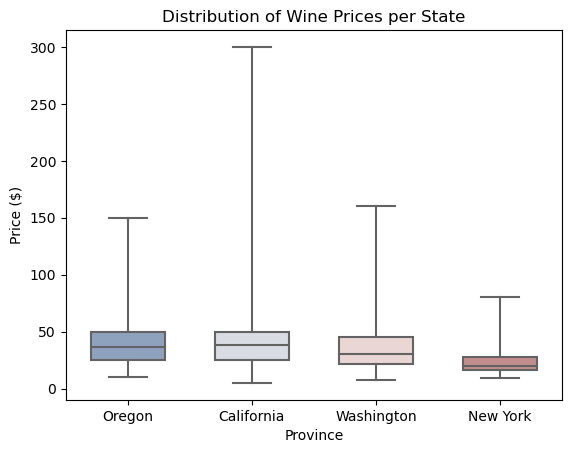

In [19]:
# Boxplot relationship between points and province
sns.boxplot(x="province", y="price", data=df, whis=[0, 100], 
width=.6, palette="vlag").set(title='Distribution of Wine Prices per State', 
                                          xlabel='Province',
                                          ylabel='Price ($)');

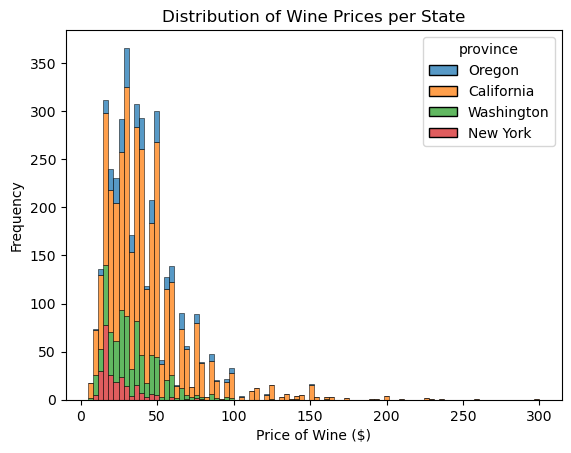

In [20]:
sns.histplot(df, x='price',hue='province', multiple='stack').set(title='Distribution of Wine Prices per State', 
                                                                 xlabel='Price of Wine ($)', 
                                                                 ylabel='Frequency' );

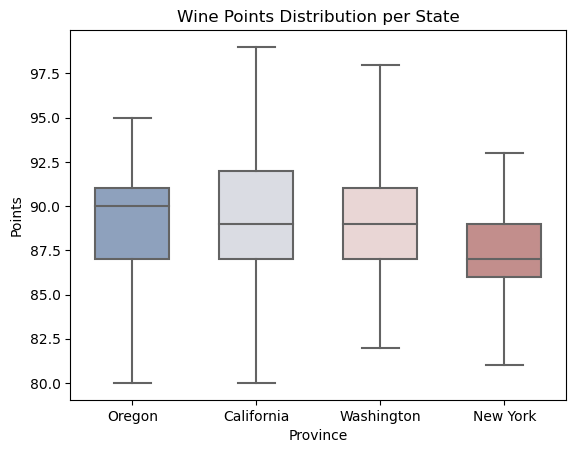

In [21]:
# Boxplot relationship between points and province
sns.boxplot(x="province", y="points", data=df, whis=[0, 100], 
            width=.6, palette="vlag").set(title='Wine Points Distribution per State', 
                                          xlabel='Province', ylabel='Points');

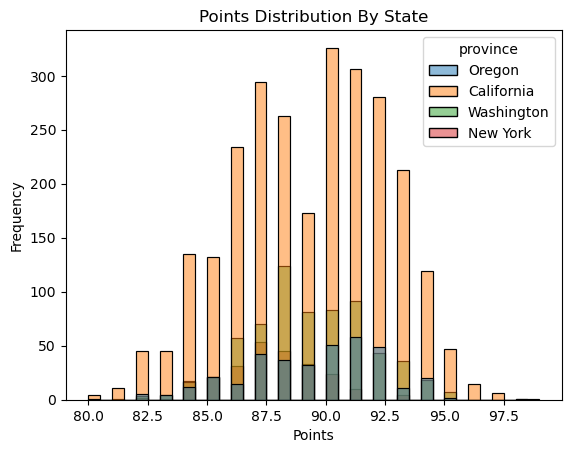

In [22]:
sns.histplot(df, x='points',hue='province').set(title='Points Distribution By State', 
                                                                  xlabel='Points', ylabel='Frequency');

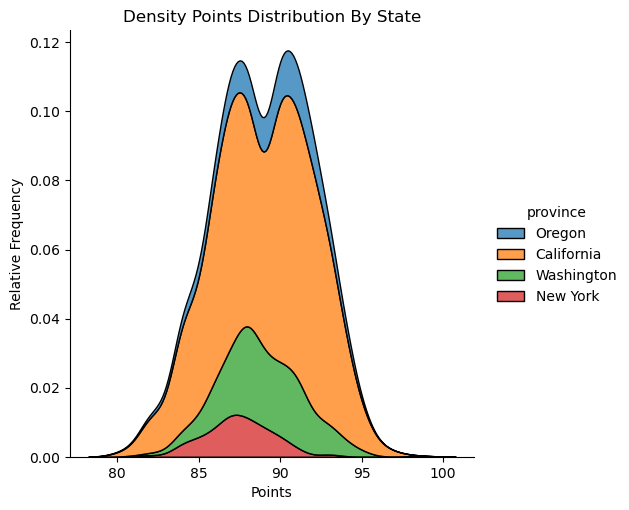

In [23]:
sns.displot(df, x="points", hue='province', kind="kde", multiple="stack").set(title='Density Points Distribution By State', 
                                                                  xlabel='Points', ylabel='Relative Frequency');

In [24]:
from collections import defaultdict

In [25]:
# Count number of times a word occures in all descriptions for all wine bottles
def_dict = defaultdict(lambda: 0)
for sentences in df['processed_description']:
    for word in sentences.split():
        def_dict[word] = def_dict[word] + 1

In [26]:
# Create df for word counts and sort in descending order by frequency. Store top 10 values
word_counts = pd.DataFrame()
word_counts['Words'] = def_dict.keys()
word_counts['Frequency'] = def_dict.values()
word_counts = word_counts.sort_values('Frequency', ascending=False)
word_counts = word_counts[:10]
word_counts

,Words,Frequency
33,flavor,1386
29,aroma,734
36,cherry,722
95,tannin,491
59,cabernet,479
195,palate,475
34,acidity,462
107,blend,444
87,ripe,442
64,note,427


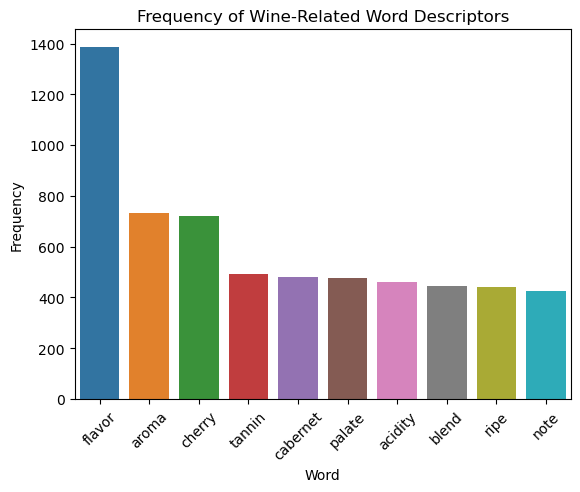

In [27]:
# Plot frequency of top 10 word occurences
sns.barplot(data=word_counts, x="Words", y="Frequency")
plt.xticks(rotation=45);
plt.title('Frequency of Wine-Related Word Descriptors')
plt.xlabel('Word');

# Natural Language Processing

There is this API available on RapidAPI for free that analyzes sentiment level and positivity score. The API docs can be found here: https://rapidapi.com/twinword/api/sentiment-analysis/

In [28]:
df_mapped.head(5)

,country,designation,points,price,province,region_1,region_2,title,variety,winery,processed_description
0,US,Vintner's Reserve Wild Child Block,87,65.0,0,Willamette Valley,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,0,0,"regular bottling come across rough rustic, her..."
1,US,Mountain Cuvée,87,19.0,1,Napa Valley,Napa,Kirkland Signature 2011 Mountain Cuvée Caberne...,1,1,supple plum envelope oaky structure supported ...
2,US,Signature Selection,87,22.0,1,Paso Robles,Central Coast,Bianchi 2011 Signature Selection Merlot (Paso ...,2,2,geneseo district offer aroma sour plum cigar t...
3,US,King Ridge Vineyard,87,69.0,1,Sonoma Coast,Sonoma,Castello di Amorosa 2011 King Ridge Vineyard P...,0,3,oak intermingle around robust aroma wet vineya...
4,US,Puma Springs Vineyard,86,50.0,1,Dry Creek Valley,Sonoma,Envolve 2010 Puma Springs Vineyard Red (Dry Cr...,3,4,"rustic flavor currants, licorice cabernet fran..."


## PCA

In [29]:
from sklearn.decomposition import PCA
import plotly.express as px

# Perform PCA with quantative features to group 
x_feat_list = ['points', 'price', 'winery', 'province', 'variety']
x_vals = df_mapped.loc[:,x_feat_list].values

pca = PCA(n_components=2, whiten=False)
x_pca = pca.fit_transform(x_vals)

# add features back into PCAdataframe (for plotting PCA)
df_mapped['PCA 0'] = x_pca[:, 0]
df_mapped['PCA 1'] = x_pca[:, 1]

# scatter plot and write to HTML graph
fig = px.scatter(df_mapped, x='PCA 0', y='PCA 1', hover_data=x_feat_list, title='Wine Types PCA Graph')
fig.write_html('wine_PCA.html')